In [1]:
#IMPORTS
import os
import cv2
import tqdm
import pickle
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [2]:
#PATH
dataset_path = "Clean_dataset"

In [3]:
#MEDIAPOSE
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5)

In [4]:
#CLASS LABELS
class_labels = {
    "downdog": 0,
    "goddess": 1,
    "plank": 2, 
    "tree": 3,
    "warrior2": 4
}
pose_label = ["Downdog","Goddess","Plank","Tree","Warrior II"]

In [5]:
#MODEL
def create_model():
    model = keras.Sequential()
    model.add(
        layers.Conv1D(
            filters=16,
            kernel_size=3,
            activation=keras.activations.relu,
            padding="same",
            input_shape=(33, 2)
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling1D())
    model.add(
        layers.Conv1D(
            filters=16,
            kernel_size=3,
            activation=keras.activations.relu,
            padding="same",
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(5, activation=keras.activations.softmax))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

In [6]:
#TRAIN MODEL
def train_model(model, train_dataset, val_dataset):
    history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)
    model.save("save/predict.model")
    return history

In [7]:
#PLOTTING ACCURACY
def plot_accgraph(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [8]:
#LOAD DATASET
def load_dataset(
        dataset_label,
        data_path,
        class_labels,
    ):
    data = []
    labels = []
    for class_name in class_labels.keys():
        path = f"{data_path}/{dataset_label}/{class_name}"
        print(f"Loading {dataset_label} Data for Class Name: {class_name}")
        for filename in tqdm.tqdm(os.listdir(path), position=0):
            image = cv2.imread(f"{path}/{filename}")
            results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if not results.pose_landmarks:
                continue
            sample = []
            for lm in results.pose_landmarks.landmark:
                sample.append((lm.x, lm.y))
            data.append(sample)
            label_sample = np.zeros(5)
            label_sample[class_labels[class_name]] = 1
            labels.append(label_sample)
    return np.array(data), np.array(labels)

In [9]:
#LOAD DATA
def load_data(data_path, class_labels):
    train_data, train_labels = load_dataset(
        "TRAIN",
        data_path,
        class_labels,
    )
    test_data, test_labels = load_dataset(
        "TEST",
        data_path,
        class_labels,
    )
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)
    return train_dataset, test_dataset

In [10]:
#LOADING DATASET
train_dataset, test_dataset = load_data(dataset_path, class_labels)

Loading TRAIN Data for Class Name: downdog


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:29<00:00,  8.24it/s]


Loading TRAIN Data for Class Name: goddess


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:16<00:00,  7.71it/s]


Loading TRAIN Data for Class Name: plank


100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [00:17<00:00,  7.73it/s]


Loading TRAIN Data for Class Name: tree


100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:21<00:00,  7.11it/s]


Loading TRAIN Data for Class Name: warrior2


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:35<00:00,  7.62it/s]


Loading TEST Data for Class Name: downdog


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:12<00:00,  7.43it/s]


Loading TEST Data for Class Name: goddess


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:11<00:00,  7.69it/s]


Loading TEST Data for Class Name: plank


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:13<00:00,  6.67it/s]


Loading TEST Data for Class Name: tree


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.29it/s]


Loading TEST Data for Class Name: warrior2


100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:12<00:00,  7.30it/s]


In [11]:
#LOADING MODEL
model = create_model()

In [12]:
#TRAINING MODEL
history=train_model(model, train_dataset, test_dataset)

Epoch 1/100
28/28 [==============================] - 0s 14ms/step - loss: 2.2502 - accuracy: 0.1995 - val_loss: 1.6151 - val_accuracy: 0.2036
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 1.9758 - accuracy: 0.2807 - val_loss: 1.6088 - val_accuracy: 0.2036
Epoch 3/100
28/28 [==============================] - 0s 2ms/step - loss: 1.7853 - accuracy: 0.3371 - val_loss: 1.6042 - val_accuracy: 0.2036
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 1.7203 - accuracy: 0.3709 - val_loss: 1.5987 - val_accuracy: 0.2036
Epoch 5/100
28/28 [==============================] - 0s 2ms/step - loss: 1.5978 - accuracy: 0.4205 - val_loss: 1.5911 - val_accuracy: 0.2036
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 1.5276 - accuracy: 0.4453 - val_loss: 1.5799 - val_accuracy: 0.2036
Epoch 7/100
28/28 [==============================] - 0s 2ms/step - loss: 1.4071 - accuracy: 0.4837 - val_loss: 1.5628 - val_accuracy: 0.2036
Epoch 8/100


Epoch 59/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8828 - val_loss: 0.5659 - val_accuracy: 0.7851
Epoch 60/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3190 - accuracy: 0.9076 - val_loss: 0.5610 - val_accuracy: 0.7873
Epoch 61/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3117 - accuracy: 0.9030 - val_loss: 0.5555 - val_accuracy: 0.7896
Epoch 62/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3173 - accuracy: 0.8997 - val_loss: 0.5565 - val_accuracy: 0.7873
Epoch 63/100
28/28 [==============================] - 0s 2ms/step - loss: 0.3233 - accuracy: 0.8974 - val_loss: 0.5548 - val_accuracy: 0.7896
Epoch 64/100
28/28 [==============================] - 0s 2ms/step - loss: 0.2949 - accuracy: 0.9019 - val_loss: 0.5546 - val_accuracy: 0.7873
Epoch 65/100
28/28 [==============================] - 0s 3ms/step - loss: 0.2793 - accuracy: 0.9121 - val_loss: 0.5521 - val_accuracy: 0.7873
Epoch 

Assets written to: save/predict.model\assets


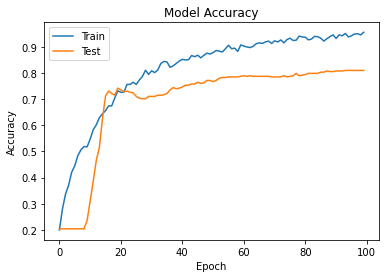

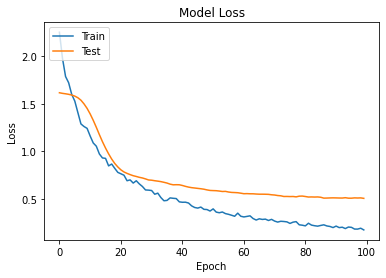

In [13]:
#ACCURACY
plot_accgraph(history)

In [5]:
#TRAINED MODEL
model = keras.models.load_model("save/predict.model")

In [6]:
#MAKE PREDICTIONS
def predict_with_static_image(model,filepath):
    input_frame = cv2.imread(filepath)
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image=input_frame)
    output_image = input_frame.copy()
    label = "Unknown Pose"
    accuracy = 0
    mp_drawing.draw_landmarks(output_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    sample = []
    for lm in results.pose_landmarks.landmark:
        sample.append((lm.x, lm.y))
    prediction = model(np.array(sample)[np.newaxis, :, :])
    p=np.array(prediction)
    label=pose_label[np.argmax(p)]
    accuracy = str(round(p[0][np.argmax(p)]*100,3)) 
    if(float(accuracy)<50):
        label = "Unknown Pose"
    return label,accuracy,output_image

In [7]:
#OUTPUT
def output(lab,acc,out):
    plt.figure(figsize = [10, 10])
    if(lab=="Unknown Pose"):
        plt.title(lab)
    else:
        plt.title(f"Pose: {lab} | Accuracy: {acc}%")
    plt.axis('off')
    plt.imshow(out)
    plt.show()

In [8]:
#PATH
path="Testing_Images/untitled-1018jpg.jpg"

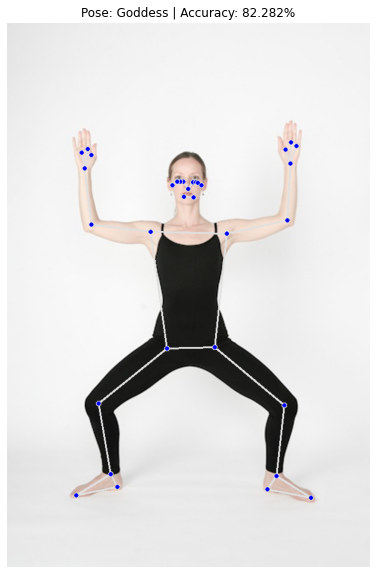

In [9]:
#MAKING PREDICTIONS
lab,acc,out=predict_with_static_image(model,path)
output(lab,acc,out)